<div style="height:200px;width:100%;margin: 0;">
    <img src="https://storage.googleapis.com/kaggle-competitions/kaggle/34547/logos/header.png?t=2022-02-15-22-37-27" style="width:100%;" />
</div>

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="credits"><center>Credits</center></h3>

This is the reverse engineering of the [hengck23 discussion](https://www.kaggle.com/code/hengck23/lb-0-75-variable-size-swin-transformer-v1-and-v2).<br>
Please upvote both discussion/notebooks if you are planning to use Swin Transformers or any part of the code.

**hengck23 owner Disclaimer**

[1] the code is taken from a larger project and is by no means complete. It will has missing import modules, etc. But these are trival functions that you can ignore or fill in yourself.

[2] you are free to use, modify the code for your own notebook or submission

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="imports"><center>Imports</center></h3>

In [1]:
FOLD = 3

In [2]:
import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [3]:
import os
import cv2
import time
import random

import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.cuda.amp as amp
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler 
from torch.utils.data import SequentialSampler
import torch.nn.functional as F
from torchmetrics.functional import dice_score
from torch.optim.lr_scheduler import StepLR

is_amp = True
import logging
import pandas as pd
from sklearn.model_selection import KFold

import numpy as np
from itertools import repeat
import collections.abc

import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="paths"><center>Paths</center></h3>

In [4]:
# !unzip archive\(2\).zip

In [5]:
# !mkdir checkpoint

In [6]:
pretrain_dir = '.'
root_dir = '.'

TRAIN = '../data/train_images_768/'
MASKS = '../data/train_masks_768/'
LABELS = '../data/train.csv'

In [7]:
data = np.load('./../data/train_masks_768/10044.npy')

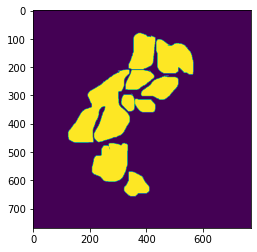

In [8]:
plt.imshow(data)
plt.show()

In [9]:
data.min(), data.max()

(0, 1)

In [10]:
2+2

4

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="additionals"><center>Additionals</center></h3>

In [11]:
def image_to_tensor(image, mode='bgr'): #image mode
    if mode=='bgr':
        image = image[:,:,::-1]
    x = image
    x = x.transpose(2,0,1)
    x = np.ascontiguousarray(x)
    x = torch.tensor(x, dtype=torch.float)
    return x


def mask_to_tensor(mask):
    x = mask
    x = torch.tensor(x, dtype=torch.float)
    return x


tensor_list = ['mask', 'image', 'organ']

def null_collate(batch):
    d = {}
    key = batch[0].keys()
    for k in key:
        v = [b[k] for b in batch]
        if k in tensor_list:
            v = torch.stack(v)
        d[k] = v

    d['mask'] = d['mask'].unsqueeze(1)
    d['organ'] = d['organ'].reshape(-1)
    return d


def _ntuple(n):
    def parse(x):
        if isinstance(x, collections.abc.Iterable):
            return x
        return tuple(repeat(x, n))
    return parse


to_2tuple = _ntuple(2)


def _no_grad_trunc_normal_(tensor, mean, std, a, b):
    # Cut & paste from PyTorch official master until it's in a few official releases - RW
    # Method based on https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn("mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
                      "The distribution of values may be incorrect.",
                      stacklevel=2)

        
def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    return _no_grad_trunc_normal_(tensor, mean, std, a, b)


def drop_path(x, drop_prob: float = 0., training: bool = False, scale_by_keep: bool = True):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.
    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = x.new_empty(shape).bernoulli_(keep_prob)
    if keep_prob > 0.0 and scale_by_keep:
        random_tensor.div_(keep_prob)
    return x * random_tensor


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob: float = 0., scale_by_keep: bool = True):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob
        self.scale_by_keep = scale_by_keep

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training, self.scale_by_keep)

    def extra_repr(self):
        return f'drop_prob={round(self.drop_prob,3):0.3f}'
    
    
class RGB(nn.Module):
    IMAGE_RGB_MEAN = [0.485, 0.456, 0.406] #[0.5, 0.5, 0.5]
    IMAGE_RGB_STD  = [0.229, 0.224, 0.225] #[0.5, 0.5, 0.5]

    def __init__(self,):
        super(RGB, self).__init__()
        self.register_buffer('mean', torch.zeros(1,3,1,1))
        self.register_buffer('std', torch.ones(1,3,1,1))
        self.mean.data = torch.FloatTensor(self.IMAGE_RGB_MEAN).view(self.mean.shape)
        self.std.data = torch.FloatTensor(self.IMAGE_RGB_STD).view(self.std.shape)

    def forward(self, x):
        x = (x-self.mean)/self.std
        return x
    
    
def message(mode='print'):
    asterisk = ' '
    if mode==('print'):
        loss = batch_loss
    if mode==('log'):
        loss = train_loss
        if (iteration % iter_save == 0): asterisk = '*'

    text = \
        ('%0.2e   %08d%s %6.2f | '%(rate, iteration, asterisk, epoch,)).replace('e-0','e-').replace('e+0','e+') + \
        '%4.3f  %4.3f  %4.4f  %4.3f   | '%(*valid_loss,) + \
        '%4.3f  %4.3f   | '%(*loss,) + \
        '%s' % ((time.time() - start_timer))

    return text

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="randoms"><center>Random choice</center></h3>

In [12]:
def valid_augment5(image, mask, organ):
    #image, mask  = do_crop(image, mask, image_size, xy=(None,None))
    return image, mask

def train_augment5b(image, mask, organ):
    image, mask = do_random_flip(image, mask)
    image, mask = do_random_rot90(image, mask)

    for fn in np.random.choice([
        lambda image, mask: (image, mask),
        lambda image, mask: do_random_noise(image, mask, mag=0.1),
        lambda image, mask: do_random_contast(image, mask, mag=0.40),
        lambda image, mask: do_random_hsv(image, mask, mag=[0.40, 0.40, 0])
    ], 2): image, mask = fn(image, mask)

    for fn in np.random.choice([
        lambda image, mask: (image, mask),
        lambda image, mask: do_random_rotate_scale(image, mask, angle=45, scale=[0.50, 2.0]),
    ], 1): image, mask = fn(image, mask)

    return image, mask

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="augmentations"><center>Augmentations</center></h3>

In [13]:
def do_random_flip(image, mask):
    if np.random.rand()>0.5:
        image = cv2.flip(image,0)
        mask = cv2.flip(mask,0)
    if np.random.rand()>0.5:
        image = cv2.flip(image,1)
        mask = cv2.flip(mask,1)
    if np.random.rand()>0.5:
        image = image.transpose(1,0,2)
        mask = mask.transpose(1,0)
    
    image = np.ascontiguousarray(image)
    mask = np.ascontiguousarray(mask)
    return image, mask

def do_random_rot90(image, mask):
    r = np.random.choice([
        0,
        cv2.ROTATE_90_CLOCKWISE,
        cv2.ROTATE_90_COUNTERCLOCKWISE,
        cv2.ROTATE_180,
    ])
    if r==0:
        return image, mask
    else:
        image = cv2.rotate(image, r)
        mask = cv2.rotate(mask, r)
        return image, mask
    
def do_random_contast(image, mask, mag=0.3):
    alpha = 1 + random.uniform(-1,1)*mag
    image = image * alpha
    image = np.clip(image,0,1)
    return image, mask

def do_random_hsv(image, mask, mag=[0.15,0.25,0.25]):
    image = (image*255).astype(np.uint8)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    h = hsv[:, :, 0].astype(np.float32)  # hue
    s = hsv[:, :, 1].astype(np.float32)  # saturation
    v = hsv[:, :, 2].astype(np.float32)  # value
    h = (h*(1 + random.uniform(-1,1)*mag[0]))%180
    s =  s*(1 + random.uniform(-1,1)*mag[1])
    v =  v*(1 + random.uniform(-1,1)*mag[2])

    hsv[:, :, 0] = np.clip(h,0,180).astype(np.uint8)
    hsv[:, :, 1] = np.clip(s,0,255).astype(np.uint8)
    hsv[:, :, 2] = np.clip(v,0,255).astype(np.uint8)
    image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    image = image.astype(np.float32)/255
    return image, mask

def do_random_noise(image, mask, mag=0.1):
    height, width = image.shape[:2]
    noise = np.random.uniform(-1,1, (height, width,1))*mag
    image = image + noise
    image = np.clip(image,0,1)
    return image, mask

def do_random_rotate_scale(image, mask, angle=30, scale=[0.8,1.2] ):
    angle = np.random.uniform(-angle, angle)
    scale = np.random.uniform(*scale) if scale is not None else 1
    
    height, width = image.shape[:2]
    center = (height // 2, width // 2)
    
    transform = cv2.getRotationMatrix2D(center, angle, scale)
    image = cv2.warpAffine( image, transform, (width, height), flags=cv2.INTER_LINEAR,
                            borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))
    mask  = cv2.warpAffine( mask, transform, (width, height), flags=cv2.INTER_LINEAR,
                            borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return image, mask

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="dataset"><center>Dataset</center></h3>

In [32]:
image_size = 768

class HubmapDataset(Dataset):
    def __init__(self, df, augment=None):

        self.df = df
        self.augment = augment
        self.length = len(self.df)
        ids = pd.read_csv(LABELS).id.astype(str).values
        self.fnames = [fname for fname in os.listdir(TRAIN)]# if fname.split('_')[0] in ids]
        self.organ_to_label = {'kidney' : 0,
                               'prostate' : 1,
                               'largeintestine' : 2,
                               'spleen' : 3,
                               'lung' : 4}

    def __str__(self):
        string = ''
        string += '\tlen = %d\n' % len(self)

        d = self.df.organ.value_counts().to_dict()
        for k in ['kidney', 'prostate', 'largeintestine', 'spleen', 'lung']:
            string +=  '%24s %3d (%0.3f) \n'%(k,d.get(k,0),d.get(k,0)/len(self.df))
        return string

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        fname = self.fnames[index]
        d = self.df.iloc[index]
        organ = self.organ_to_label[d.organ]

        image = cv2.cvtColor(cv2.imread(os.path.join(TRAIN,fname)), cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.show()
        
#         mask = cv2.imread(os.path.join(MASKS,fname),cv2.IMREAD_GRAYSCALE)
        mask = np.load(os.path.join(MASKS,fname.replace('.png', '.npy')),cv2.IMREAD_GRAYSCALE)

        
        image = image.astype(np.float32)/255
        mask  = mask.astype(np.float32) #/255

#         s = d.pixel_size/0.4 * (image_size/3000)
        image = cv2.resize(image,dsize=(image_size,image_size),interpolation=cv2.INTER_LINEAR)
        mask  = cv2.resize(mask, dsize=(image_size,image_size),interpolation=cv2.INTER_LINEAR)

        if self.augment is not None:
            image, mask = self.augment(image, mask, organ)


        r ={}
        r['index']= index
        r['id'] = fname
        r['organ'] = torch.tensor([organ], dtype=torch.long)
        r['image'] = image_to_tensor(image)
        r['mask' ] = mask_to_tensor(mask>0.5)
        return r

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="patching"><center>NETWORK</center></h3>

In [15]:
from swintransformer import *

In [16]:
def run_check_net():
    batch_size = 2
    image_size = 512

    #---
    batch = {
        'image' : torch.from_numpy( np.random.uniform(-1,1,(batch_size,3,image_size,image_size)) ).float(),
        'mask'  : torch.from_numpy( np.random.choice(2,(batch_size,1,image_size,image_size)) ).float(),
        'organ' : torch.from_numpy( np.random.choice(5,(batch_size)) ).long(),
    }
    batch = {k:v.cuda() for k,v in batch.items()}

    net = Net().cuda()
    net.load_pretrain()

    with torch.no_grad():
        with torch.cuda.amp.autocast(enabled=True):
            output = net(batch)

    print('batch')
    for k,v in batch.items():
        print('%32s :'%k, v.shape)

    print('output')
    for k,v in output.items():
        if 'loss' not in k:
            print('%32s :'%k, v.shape)
    for k,v in output.items():
        if 'loss' in k:
            print('%32s :'%k, v.item())

In [17]:
cfg = dict(

        #configs/_base_/models/upernet_swin.py
        basic = dict(
            swin=dict(
                embed_dim=96,
                depths=[2, 2, 6, 2],
                num_heads=[3, 6, 12, 24],
                window_size=7,
                mlp_ratio=4.,
                qkv_bias=True,
                qk_scale=None,
                drop_rate=0.,
                attn_drop_rate=0.,
                drop_path_rate=0.3,
                ape=False,
                patch_norm=True,
                out_indices=(0, 1, 2, 3),
                use_checkpoint=False
            ),

        ),

        #configs/swin/upernet_swin_tiny_patch4_window7_512x512_160k_ade20k.py
        swin_tiny_patch4_window7_224=dict(
            checkpoint = pretrain_dir+'/swin_tiny_patch4_window7_224_22k.pth',

            swin = dict(
                embed_dim=96,
                depths=[2, 2, 6, 2],
                num_heads=[3, 6, 12, 24],
                window_size=7,
                ape=False,
                drop_path_rate=0.3,
                patch_norm=True,
                use_checkpoint=False,
            ),
            upernet=dict(
                in_channels=[96, 192, 384, 768],
            ),
        ),

        #/configs/swin/upernet_swin_small_patch4_window7_512x512_160k_ade20k.py
        swin_small_patch4_window7_224_22k=dict(
            checkpoint = pretrain_dir+'/swin_small_patch4_window7_224_22k.pth',

            swin = dict(
                embed_dim=96,
                depths=[2, 2, 18, 2],
                num_heads=[3, 6, 12, 24],
                window_size=7,
                ape=False,
                drop_path_rate=0.3,
                patch_norm=True,
                use_checkpoint=False
            ),
            upernet=dict(
                in_channels=[96, 192, 384, 768],
            ),
        ),
    )

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="folds"><center>Folds</center></h3>

In [15]:
def make_fold(fold=0):
    df = pd.read_csv(root_dir + '/../data/train.csv')

    num_fold = 5
    skf = KFold(n_splits=num_fold, shuffle=True,random_state=42)

    df.loc[:,'fold']=-1
    for f,(t_idx, v_idx) in enumerate(skf.split(X=df['id'], y=df['organ'])):
        df.iloc[v_idx,-1]=f

    #check
    if 0:
        for f in range(num_fold):
            train_df=df[df.fold!=f].reset_index(drop=True)
            valid_df=df[df.fold==f].reset_index(drop=True)

            print('fold %d'%f)
            t = train_df.organ.value_counts().to_dict()
            v = valid_df.organ.value_counts().to_dict()
            for k in ['kidney', 'prostate', 'largeintestine', 'spleen', 'lung']:
                print('%32s %3d (%0.3f)  %3d (%0.3f)'%(k,t.get(k,0),t.get(k,0)/len(train_df),v.get(k,0),v.get(k,0)/len(valid_df)))

            print('')
            zz=0

    train_df=df[df.fold!=fold].reset_index(drop=True)
    valid_df=df[df.fold==fold].reset_index(drop=True)
    return train_df,valid_df

In [33]:
train_df, valid_df = make_fold(0)

hubdataset = HubmapDataset(train_df, train_augment5b)

In [45]:
import cv2 as cv
import tifffile

In [57]:
FILENAME = '32741'

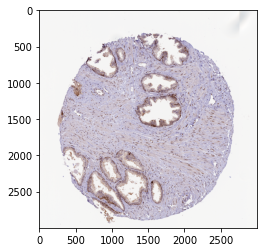

In [58]:
img = tifffile.imread('./../data/train_images/' + FILENAME + '.tiff')
plt.imshow(img)
plt.show()

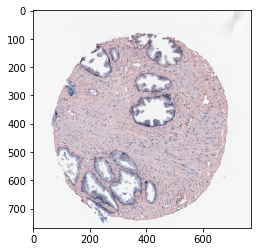

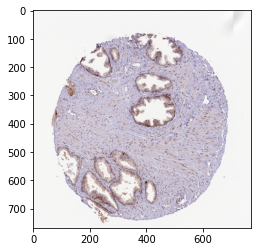

In [59]:
img = cv.imread('./../data/train_images_768/' + FILENAME + '.png')
img = img[:, :, ::-1]
plt.imshow(img)
plt.show()
plt.imshow(img[:, :, ::-1])
plt.show()

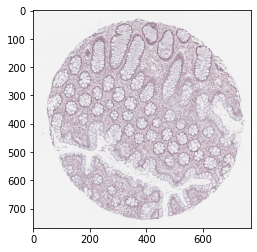

1


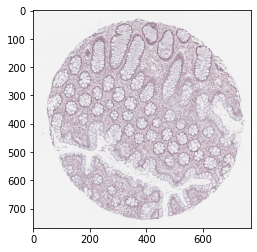

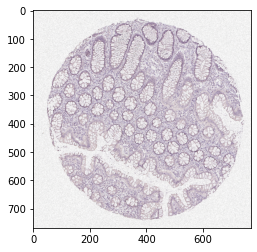

tensor(0.1215) tensor(1.)


In [60]:
print(hubdataset[1]['index'])
img = hubdataset[1]['image'].permute((1, 2, 0))
plt.imshow(img)
plt.show()
print(img.min(), img.max())

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="dice_score"><center>Competition Metric</center></h3>

In [19]:
def compute_dice_score(probability, mask):
    N = len(probability)
    p = probability.reshape(N,-1)
    t = mask.reshape(N,-1)

    p = p>0.5
    t = t>0.5
    uion = p.sum(-1) + t.sum(-1)
    overlap = (p*t).sum(-1)
    dice = 2*overlap/(uion+0.0001)
    return dice

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="validation"><center>Validation</center></h3>

In [20]:
def validate(net, valid_loader):

    valid_num = 0
    valid_probability = []
    valid_mask = []
    valid_loss = 0

    net = net.eval()
    start_timer = time.time()
    for t, batch in enumerate(valid_loader):

        net.output_type = ['loss', 'inference']
        with torch.no_grad():
            with amp.autocast(enabled = is_amp):

                batch_size = len(batch['index'])
                batch['image'] = batch['image'].cuda()
                batch['mask' ] = batch['mask' ].cuda()
                batch['organ'] = batch['organ'].cuda()

                output = net(batch)
                loss0  = output['bce_loss'].mean()

        valid_probability.append(output['probability'].data.cpu().numpy())
        valid_mask.append(batch['mask'].data.cpu().numpy())
        valid_num += batch_size
        valid_loss += batch_size*loss0.item()

        #debug
        if 0 :
            pass
            organ = batch['organ'].data.cpu().numpy()
            image = batch['image']
            mask  = batch['mask']
            probability  = output['probability']

            for b in range(batch_size):
                m = tensor_to_image(image[b])
                t = tensor_to_mask(mask[b,0])
                p = tensor_to_mask(probability[b,0])
                overlay = result_to_overlay(m, t, p )

                text = label_to_organ[organ[b]]
                draw_shadow_text(overlay,text,(5,15),0.7,(1,1,1),1)

                image_show_norm('overlay',overlay,min=0,max=1,resize=1)
                cv2.waitKey(0)

        print('\r %8d / %d  %s'%(valid_num, len(valid_loader.dataset),(time.time() - start_timer)),end='',flush=True)

    assert(valid_num == len(valid_loader.dataset))

    probability = np.concatenate(valid_probability)
    mask = np.concatenate(valid_mask)

    loss = valid_loss/valid_num

    dice = compute_dice_score(probability, mask)
    dice = dice.mean()
    
    return [dice, loss,  0, 0]

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="init"><center>Initialization</center></h3>

In [21]:
def get_learning_rate(optimizer):
    return optimizer.param_groups[0]['lr']

In [22]:
# !mkdir fold_0

In [23]:
fold = FOLD

out_dir = root_dir + '/fold-%d' % (fold)
initial_checkpoint = None

start_lr   = 5e-5 #0.0001
batch_size = 8 #32 #32


## setup  ----------------------------------------
for f in ['checkpoint','train','valid','backup'] : os.makedirs(out_dir +'/'+f, exist_ok=True)

    
log = open(out_dir+'/log.train.txt',mode='a')
log.write('\n--- [START %s] %s\n\n' % ('Swin', '-' * 64))
log.write('\n')


## dataset ----------------------------------------
log.write('** dataset setting **\n')

train_df, valid_df = make_fold(fold)

train_dataset = HubmapDataset(train_df, train_augment5b)
valid_dataset = HubmapDataset(valid_df, valid_augment5)

train_loader  = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset),
    batch_size  = batch_size,
    drop_last   = True,
    num_workers = 8,
    pin_memory  = False,
    worker_init_fn = lambda id: np.random.seed(torch.initial_seed() // 2 ** 32 + id),
    collate_fn = null_collate,
)

valid_loader = DataLoader(
    valid_dataset,
    sampler = SequentialSampler(valid_dataset),
    batch_size  = 8,
    drop_last   = False,
    num_workers = 4,
    pin_memory  = False,
    collate_fn = null_collate,
)


log.write('fold = %s\n'%str(fold))
log.write('train_dataset : \n%s\n'%(train_dataset))
log.write('valid_dataset : \n%s\n'%(valid_dataset))
log.write('\n')


## net ----------------------------------------
log.write('** net setting **\n')

scaler = amp.GradScaler(enabled = is_amp)
net = Net(cfg).cuda()

if initial_checkpoint is not None:
    f = torch.load(initial_checkpoint, map_location=lambda storage, loc: storage)
    start_iteration = f['iteration']
    start_epoch = f['epoch']
    state_dict  = f['state_dict']
    net.load_state_dict(state_dict,strict=False)  #True
else:
    start_iteration = 0
    start_epoch = 0
    net.load_pretrain()


log.write('\tinitial_checkpoint = %s\n' % initial_checkpoint)
log.write('\n')


## optimiser ----------------------------------
if 0: ##freeze
    for p in net.stem.parameters():   p.requires_grad = False
    pass

def freeze_bn(net):
    for m in net.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.eval()
            m.weight.requires_grad = False
            m.bias.requires_grad = False
            
#freeze_bn(net)

#-----------------------------------------------

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, net.parameters()),
                              lr=start_lr)

log.write('optimizer\n  %s\n'%(optimizer))
log.write('\n')

num_iteration = 1000*len(train_loader)
iter_log   = len(train_loader)*3 #479
iter_valid = iter_log
iter_save  = iter_log

loading ./swin_tiny_patch4_window7_224_22k.pth ...
_IncompatibleKeys(missing_keys=['out_norm.0.weight', 'out_norm.0.bias', 'out_norm.1.weight', 'out_norm.1.bias', 'out_norm.2.weight', 'out_norm.2.bias', 'out_norm.3.weight', 'out_norm.3.bias'], unexpected_keys=['norm.weight', 'norm.bias', 'head.weight', 'head.bias', 'layers.0.blocks.1.attn_mask', 'layers.1.blocks.1.attn_mask', 'layers.2.blocks.1.attn_mask', 'layers.2.blocks.3.attn_mask', 'layers.2.blocks.5.attn_mask'])


In [24]:
train_df

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,fold
0,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,4
1,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,2
2,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,0
3,10611,kidney,HPA,3000,3000,0.4,4,730193 18 733191 25 736191 25 739152 65 742149...,68.0,Female,0
4,10651,largeintestine,HPA,3000,3000,0.4,4,1240229 12 1243227 15 1246223 26 1249221 29 12...,83.0,Male,1
5,10666,prostate,HPA,3000,3000,0.4,4,2698231 7 2701231 7 2704226 16 2707221 25 2710...,57.0,Male,1
6,10892,largeintestine,HPA,3000,3000,0.4,4,523786 3 526784 8 529782 8 532778 9 535642 25 ...,79.0,Female,0
7,10912,prostate,HPA,3000,3000,0.4,4,1147323 50 1150316 59 1153309 68 1156303 76 11...,60.0,Male,1
8,10971,prostate,HPA,3000,3000,0.4,4,1507862 60 1510857 69 1513853 77 1516848 86 15...,60.0,Male,2
9,11064,lung,HPA,3000,3000,0.4,4,2210040 68 2213039 70 2216036 74 2219032 79 22...,65.0,Male,4


<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="training"><center>Training</center></h3>

In [25]:
# !rm -rf fold-0

In [26]:
# !rm -rf fold-1

In [27]:
# !rm -rf fold-2

In [ ]:
log.write('** start training here! **\n')
log.write('   batch_size = %d \n'%(batch_size))
log.write('                     |-------------- VALID---------|---- TRAIN/BATCH ----------------\n')
log.write('rate     iter  epoch | dice   loss   tp     tn     | loss           | time           \n')
log.write('-------------------------------------------------------------------------------------\n')

valid_loss = np.zeros(4,np.float32)
train_loss = np.zeros(2,np.float32)
batch_loss = np.zeros_like(train_loss)
sum_train_loss = np.zeros_like(train_loss)
sum_train = 0

start_timer = time.time()
iteration = start_iteration
epoch = start_epoch
rate = 0

while iteration < num_iteration:
    for t, batch in enumerate(train_loader):

        if iteration%iter_save==0:
            if iteration != start_iteration:
                torch.save({
                    'state_dict': net.state_dict(),
                    'iteration': iteration,
                    'epoch': epoch,
                }, out_dir + '/checkpoint/%08d.model.pth' %  (iteration))
                pass


        if (iteration%iter_valid==0):
            valid_loss = validate(net, valid_loader)
            pass


        if (iteration%iter_log==0) or (iteration%iter_valid==0):
            print('\r', end='', flush=True)
            log.write(message(mode='log') + '\n')


        # learning rate schduler ------------
        rate = get_learning_rate(optimizer)

        # one iteration update  -------------
        batch_size = len(batch['index'])
        batch['image'] = batch['image'].half().cuda()
        batch['mask' ] = batch['mask' ].half().cuda()
        batch['organ'] = batch['organ'].cuda()


        net.train()
        net.output_type = ['loss']
        if 1:
            with amp.autocast(enabled = is_amp):
                output = net(batch)
                loss0  = output['bce_loss'].mean()
                loss1  = output['aux2_loss'].mean()

            optimizer.zero_grad()
            scaler.scale(loss0+0.2*loss1).backward()

            scaler.unscale_(optimizer)
            scaler.step(optimizer)
            scaler.update()


        # print statistics  --------
        batch_loss[:2] = [loss0.item(),loss1.item()]
        sum_train_loss += batch_loss
        sum_train += 1
        if t % 100 == 0:
            train_loss = sum_train_loss / (sum_train + 1e-12)
            sum_train_loss[...] = 0
            sum_train = 0

        print('\r', end='', flush=True)
        print(message(mode='log'), end='', flush=True)
        epoch += 1 / len(train_loader)
        iteration += 1
        
    torch.cuda.empty_cache()
    log.flush()
    clear_output()
    
log.write('\n')
log.close()

5.00e-5   00001056   30.17 | 0.746  0.089  0.0000  0.000   | 0.138  0.137   | 704.32299137115480.138  0.137   | 700.9115068912506

In [ ]:
iteration

In [ ]:
num_iteration

In [ ]:
# !rm -rf fold-0